<h3> The Perceptron </h3>

Today we will build a perceptron that will allow us to determine whether a patient has a sleep disorder or not. We will build it and train it from scratch using only the numpy library, with the additional support of pandas to load the data and matplotlib to visualize the training process and results.

<center>
    <figure>
    <img src="perceptron-diagram.png" alt="perceptron" width="75%"/>
      <figcaption>Schematic representation of a Perceptron</figcaption>
    </figure>
</center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Exercise 1** - Load the data from the sleep_disorder_data.csv file with pandas and visualize it in the notebook.

In [2]:
df = pd.read_csv('sleep_disorder_data.csv', index_col=False)
df.head()

,Patient ID,Sleep Quality,Exercise (min/day),Stress Level,Sleep Disorder
0,1.0,7.0,30.0,4.0,0.0
1,2.0,5.0,20.0,8.0,1.0
2,3.0,8.0,60.0,8.0,0.0
3,4.0,9.0,0.0,1.0,0.0
4,5.0,6.5,25.0,6.0,1.0


**Exercise 2** - Select the columns Sleep Quality, Exercise (min/day) and Stress Level as your input data `X` and the column Sleep Disorder as your target `y`

In [3]:
X = df[['Sleep Quality', 'Exercise (min/day)', 'Stress Level']].to_numpy()
y = df['Sleep Disorder'].to_numpy()

**Exercise 3** - Standardize the data matrix `X` such that each element in the resulting matrix is the following:

\begin{equation}
x_i^j:=\frac{x_i^j-\mu^j}{\sigma^j},
\end{equation}

where $x_i^j$ is the $i$th data point in the $j$th column and $\mu_j$ and $\sigma_j$ are the mean and standard deviation, respectively, of the $j$th column (note that $\sigma_j$ refers to the standard deviation of column $j$ of the feature space and is not related to the sigmoid function $\sigma$)

In [4]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

Now it is time to start building the model. Since the elements in the training set are 3 dimensional (we are looking at 3 features: Sleep Quality, Exercise and Stress Level) our single neuron model will have 3 weights and 1 bias.

**Exercise 4** - Initialize a matrix of random weights of shape (3,1) and a bias of shape (1,) between -1 and 1, store them in two variables called `weights` and `bias` and print them. Use the random seed 6 for reproducibility.

In [5]:
np.random.seed(6)
weights = np.random.random((3,1)) * 2 - 1
bias = np.random.rand(1)
print(weights)
print(bias)

[[ 0.7857203 ]
 [-0.33604039]
 [ 0.64245825]]
[0.04169663]


The next step is to define the forward function. The output is given by the weighted sum of the inputs plus the bias, which then goes through a sigmoid function to produce the final prediction $\hat{y}$:

\begin{equation}
\hat{y}=\sigma(w_1x_1+w_2x_2+w_3x_3+b)
\end{equation}

Given an input column vector $\vec{x}=\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}$, a weight matrix $W=\begin{bmatrix}w_1 \\ w_2 \\ w_3\end{bmatrix}$ and a bias $b$ we can express the linear combination of the weights and inputs plus the bias in matrix form as

\begin{equation}
W^T\vec{x}+b=\begin{bmatrix}w_1 & w_2 & w_3\end{bmatrix}\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}+b=w_1x_1+w_2x_2+w_3x_3+b
\end{equation}

which gives the following expression for the prediction:

\begin{equation}
\hat{y}=\sigma(W^T\vec{x}+b)
\end{equation}

In our case, since each column represents a feature and observations are represented by rows, we also need to transpose the input matrix `X`.

**Exercise 5** - Define a function called `sigmoid` that takes an input `x` and returns the following:

\begin{equation}
\sigma(x)=\frac{1}{1+e^{-x}}
\end{equation}

remember that you can use `np.exp(x)` to raise $e^x$

In [6]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

**Exercise 6** - Define a function called `forward` that takes 3 inputs: the weights, the bias and the data matrix `X` and returns the output of the perceptron:

\begin{equation}
\hat{y}=\sigma(W^TX+b)
\end{equation}

Tip: use the previously defined `sigmoid` function.

In [7]:
def forward(data, weights, bias):
    return sigmoid(np.dot(weights.T, data.T) + bias)

**Exercise 7** - Make an initial prediction with the untrained model using the `forward` function that you just defined. You should visualize two outputs: the plain output and the rounded output, which will be 1 or 0 for each data point. Compare your predictions with the target $y$. How many did you get right?

In [8]:
output = forward(X, weights, bias)
y_pred = np.round(output)
correct = int(np.sum(1 - np.abs(y - np.round(y_pred))))

print('raw output:', output)
print('predictions:', y_pred)
print('targets:', y)
print(f'number of correct predictions: {correct}/5', )

raw output: [[0.39958199 0.39559665 0.65037251 0.6329205  0.46856488]]
predictions: [[0. 0. 1. 1. 0.]]
targets: [0. 1. 0. 0. 1.]
number of correct predictions: 1/5


**Exercise 8** - Define a function called `mse_loss` that calculates the mean squared error:

\begin{equation}
MSE=\frac{1}{n}\sum(y-\hat{y})^2
\end{equation}

In [9]:
def loss_function(y, y_pred):
    return np.mean((y - y_pred)**2)

Before moving on to the final training loop, we need to define a function that updates the weights according to the value of the gradient, which gives us information about which direction we have to move in order to minimize the loss function. The derivative of the sigmoid function is $\sigma(z)'=\sigma(z)(1-\sigma(z))$ and the gradient of the loss function $L$ for some input vector $\vec{x}$ and target $y$ is given by 

\begin{equation}
\nabla L(x,y)=\begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2} \\
           \frac{\partial L}{\partial w_3} \\
           \frac{\partial L}{\partial b} 
         \end{bmatrix}=\begin{bmatrix}
         -2x_1\left[\left(1-\sigma(x)\right)\sigma(x)\right]\left[y-\sigma(x)\right] \\
         -2x_2\left[\left(1-\sigma(x)\right)\sigma(x)\right]\left[y-\sigma(x)\right] \\
         -2x_3\left[\left(1-\sigma(x)\right)\sigma(x)\right]\left[y-\sigma(x)\right] \\
         -2\left[\left(1-\sigma(x)\right)\sigma(x)\right]\left[y-\sigma(x)\right]
         \end{bmatrix}
         \end{equation}

**Exercise 9** - Define a function called `compute_gradient` that takes as input the data matrix $X$ the target $y$, the weights and the bias and returns the gradient of the loss function $L$ as a tuple: the first value is an array with three entries consisting of the derivative of the loss function with respect to each weight and the second value is the derivative of the loss function with respect to the bias.

In [10]:
def compute_gradient(inputs, targets, weights, bias):
    y_pred = forward(inputs, weights, bias)
    grad = -2 * ((1 - y_pred) * y_pred) * (targets - y_pred)
    weights_grad = np.dot(grad, X).T
    bias_grad = np.mean(grad)
    return weights_grad, bias_grad

Finally, we need to define the training loop. At each step, we will use `X` as the input and `y` as the target that we will compare to the output, and we will update the weights such that the error decreases.

**Exercise 10** - Define a training loop with 30 epochs and learning rate $\alpha=0.1$. Use the previously defined `compute_gradient` function and update the weights accordingly. At each step, print the loss and store it in a list.

In [11]:
learning_rate = 0.1
loss_per_epoch = []

for epoch in range(30):
    y_pred = forward(X, weights, bias)
    loss = loss_function(y, y_pred)
    print(loss)
    loss_per_epoch.append(loss)
    weights_grad, bias_grad = compute_gradient(X, y, weights, bias)
    weights -= learning_rate * weights_grad
    bias -= learning_rate * bias_grad

0.3261930464552731
0.29034458333530544
0.25816223826607104
0.23063027814622625
0.20768953128602438
0.18868914419803953
0.17284175943692043
0.15945797817460422
0.1480059208574001
0.1380938748332618
0.1294346048727347
0.12181356959855986
0.1150659154624287
0.109061199180384
0.10369358488596792
0.09887556059965373
0.09453380751867302
0.09060636071729258
0.08704055035736198
0.08379143121013413
0.08082053574055023
0.07809485677961925
0.07558600385139139
0.07326949737341296
0.07112417575176436
0.0691316964743753
0.06727611605649539
0.06554353628429081
0.0639218061888249
0.062400270812626446


**Exercise 11** - Plot the loss per epoch. Label the x-axis 'Epoch' and the y-axis 'Loss (MSE)', both with font size 14. Is the perceptron learning from the training data?

Text(0, 0.5, 'Loss (MSE)')

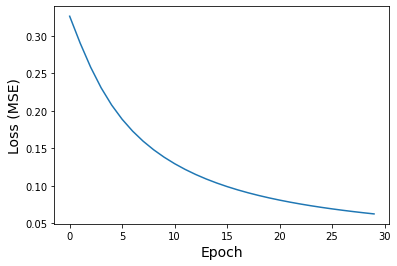

In [12]:
plt.plot(loss_per_epoch)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)

**Exercise 12** - Print the final weights matrix and the bias. How do they compare with the initial weights and bias from exercise 4? Which features are positively correlated and which ones negatively correlated with the presence of a sleep disorder?

In [13]:
print(weights)
print(bias)

[[-0.68898396]
 [-1.05789923]
 [ 1.2552708 ]]
[-0.07085526]


**Exercise 13** - Make a final prediction with the trained model and compare it to the target $y$. How many of your predictions are correct? What is the accuracy of your model?

In [14]:
y_pred = np.round(forward(X, weights, bias))
correct = int(np.sum(1 - np.abs(y - np.round(y_pred))))
accuracy = (1 - np.mean(np.abs(y - y_pred))) * 100

print('predictions: ', y_pred)
print('targets: ', y)
print(f'number of correct predictions: {correct}/5', )
print(f'accuracy: {int(accuracy)}%')

predictions:  [[0. 1. 0. 0. 1.]]
targets:  [0. 1. 0. 0. 1.]
number of correct predictions: 5/5
accuracy: 100%
